In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from modules.dataset import *
from modules.network import *
from modules.embeddings import *
from torch import save, device, cuda
from torch.utils.data import DataLoader

In [2]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


In [3]:
# Set local paths
images_path = "./images"
res_path = "./data/losses"

# Dataset

## Loading and preprocessing

In [4]:
#%%Loading the dataset 

min_len = 10
dataset = Mobydick('./data/mobydick.txt', min_len = min_len)

with open('./data/clean_text', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    
len(dataset)

466

In [5]:
# Given a min_len>2, it is not necessary to delete the chapters titles
print(dataset[0])

['some', 'years', 'ago', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'i', 'thought', 'i', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']


Mean sentence length: 30.446351931330472
Max sentence length: 127
Min sentence length: 10


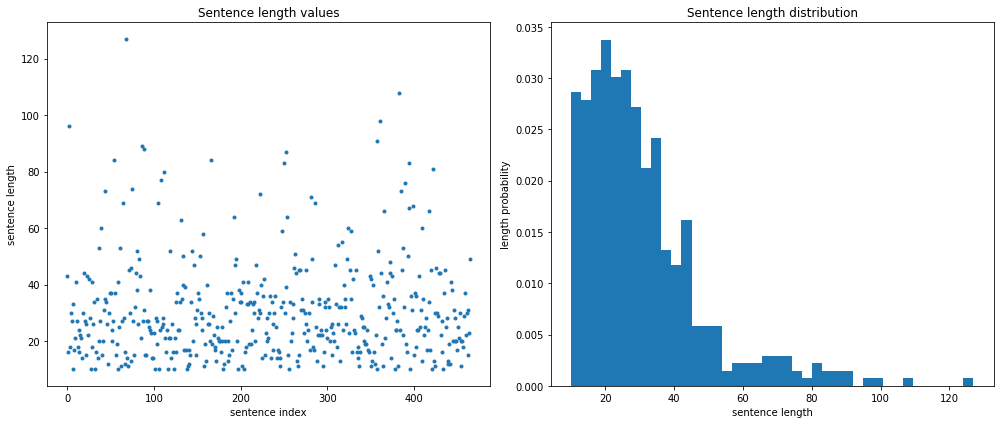

In [6]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/md_{min_len}.png')
plt.show()

In [7]:
print(len(dataset.words))

14188


## Word embeddings

In [8]:
# Define the embedding dimension
embedding_dim = 50

# Copy dataset words
words = set(dataset.words.copy())

In [9]:
# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [10]:
crop_len = 8

# Define transformation 
dataset.transform = transforms.Compose([
    RandomCrop(crop_len),
    WordToVector(words),
    ToTensor()
])

In [11]:
# Defined the transform, this call returns the word index (after random cropping)
dataset[0].shape

torch.Size([8])

# LSTM

In [12]:
##Parameters

params = {
        # network
        'hidden_units' : 2**8, # symmetric layers
        'layers_num' : 2,
        'dropout_prob' : 0.4,

        # training
        'batch_size' : 100,
        'num_epochs' : 400,

        # optimizer
        'lr' : 1e-2,
        'wd' : 1e-3,
    
        # dataset
        'crop_len' : crop_len,
        'min_len' : min_len
        }

# save
out_dir = f'LSTM_{crop_len}_{min_len}'+'_{}_{}'.format(params['lr'],params['wd'])

In [13]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [14]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = 'LSTM',
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['wd'])
# Define loss function
loss_fn = nn.MSELoss()
# loss_fn = nn.NLLLoss()

net.to(device)

Network(
  (rnn): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.4)
  (out): Linear(in_features=256, out_features=50, bias=True)
  (embed): Embedding(2998, 50)
)

In [ ]:
%%time

#%% Train network

# Define losses containers
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(params['num_epochs']):
    print('\n\n EPOCH %d/%d' % (epoch + 1, params['num_epochs']))
    
    # Set training mode
    net.train()
    # Define losses container for one epoch
    train_loss_log = []
    
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log.append(batch_loss)
        # print('\t Training loss (single batch):', batch_loss)
        
    print('\t Training loss (epoch - mean): ', np.mean(train_loss_log) )
    train_loss_epochs.append(np.mean(train_loss_log))
    
    # Set evaluation mode
    net.eval()
    val_loss_log = []
    with torch.no_grad():
        for batch_sample in test_dataloader:
            batch = batch_sample.long().to(device)
            val_loss = net.test_batch(batch, loss_fn)
            val_loss_log.append(val_loss)
            
        print('\t Validation loss (epoch - mean):', np.mean(val_loss_log))
        val_loss_epochs.append(np.mean(val_loss_log))
        
    # Early stopping
    # if epoch>200 and abs(val_loss_epochs[-1] - val_loss_epochs[-200]) < 1e-10:
    #    break
    
losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs, 'params' : params }

# Save losses dictionary
with open(res_path + "/" + out_dir, 'wb') as f:
    pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)
    
# Save model 
torch.save(net.state_dict(), res_path + "/state_" + out_dir + '.pth')



 EPOCH 1/400
	 Training loss (epoch - mean):  0.604346489906311
	 Validation loss (epoch - mean): 0.2909357246566326


 EPOCH 2/400
	 Training loss (epoch - mean):  0.2659580856561661
	 Validation loss (epoch - mean): 0.175277053834276


 EPOCH 3/400
	 Training loss (epoch - mean):  0.20076326429843902
	 Validation loss (epoch - mean): 0.18082856640536735


 EPOCH 4/400
	 Training loss (epoch - mean):  0.17434098422527314
	 Validation loss (epoch - mean): 0.14016363880735763


 EPOCH 5/400
	 Training loss (epoch - mean):  0.15322765707969666
	 Validation loss (epoch - mean): 0.1190416602853765


 EPOCH 6/400
	 Training loss (epoch - mean):  0.12382156550884246
	 Validation loss (epoch - mean): 0.11382736210176285


 EPOCH 7/400
	 Training loss (epoch - mean):  0.11108192652463914
	 Validation loss (epoch - mean): 0.13354053019367634


 EPOCH 8/400
	 Training loss (epoch - mean):  0.11069621592760086
	 Validation loss (epoch - mean): 0.09671231386984916


 EPOCH 9/400
	 Training loss 

	 Training loss (epoch - mean):  0.005885407421737909
	 Validation loss (epoch - mean): 0.005120856315346479


 EPOCH 68/400
	 Training loss (epoch - mean):  0.006047454848885536
	 Validation loss (epoch - mean): 0.005361946253075037


 EPOCH 69/400
	 Training loss (epoch - mean):  0.005354845244437456
	 Validation loss (epoch - mean): 0.005392014855076807


 EPOCH 70/400
	 Training loss (epoch - mean):  0.004422827437520027
	 Validation loss (epoch - mean): 0.00398079645473193


 EPOCH 71/400
	 Training loss (epoch - mean):  0.005060135200619697
	 Validation loss (epoch - mean): 0.003941442005096643


 EPOCH 72/400
	 Training loss (epoch - mean):  0.004558425862342119
	 Validation loss (epoch - mean): 0.005964369525479034


 EPOCH 73/400
	 Training loss (epoch - mean):  0.004509247187525034
	 Validation loss (epoch - mean): 0.004211716131589553


 EPOCH 74/400
	 Training loss (epoch - mean):  0.0040460960939526554
	 Validation loss (epoch - mean): 0.0035959493823688815


 EPOCH 75/400

	 Training loss (epoch - mean):  0.0002403679915005341
	 Validation loss (epoch - mean): 0.00025134567598836434


 EPOCH 133/400
	 Training loss (epoch - mean):  0.00021554066915996373
	 Validation loss (epoch - mean): 0.00024127113390767725


 EPOCH 134/400
	 Training loss (epoch - mean):  0.00021204424556344747
	 Validation loss (epoch - mean): 0.00020874891320489796


 EPOCH 135/400
	 Training loss (epoch - mean):  0.00019230414181947708
	 Validation loss (epoch - mean): 0.00017834293962798808


 EPOCH 136/400
	 Training loss (epoch - mean):  0.00018357616208959372
	 Validation loss (epoch - mean): 0.0001782819967364416


 EPOCH 137/400
	 Training loss (epoch - mean):  0.0001823671133024618
	 Validation loss (epoch - mean): 0.00015744066678507202


 EPOCH 138/400
	 Training loss (epoch - mean):  0.00017357171745970845
	 Validation loss (epoch - mean): 0.0001277816516349617


 EPOCH 139/400
	 Training loss (epoch - mean):  0.0001569270680192858
	 Validation loss (epoch - mean): 0.000

	 Training loss (epoch - mean):  2.65181533904979e-06
	 Validation loss (epoch - mean): 2.6711525069564254e-06


 EPOCH 197/400
	 Training loss (epoch - mean):  2.3897991468402326e-06
	 Validation loss (epoch - mean): 2.511068774284689e-06


 EPOCH 198/400
	 Training loss (epoch - mean):  2.2703429976900224e-06
	 Validation loss (epoch - mean): 1.6998715286439755e-06


 EPOCH 199/400
	 Training loss (epoch - mean):  2.0477386215134173e-06
	 Validation loss (epoch - mean): 1.8909834753469236e-06


 EPOCH 200/400
	 Training loss (epoch - mean):  1.963896056622616e-06
	 Validation loss (epoch - mean): 1.8456179673159357e-06


 EPOCH 201/400
	 Training loss (epoch - mean):  1.7255674038096914e-06
	 Validation loss (epoch - mean): 2.020959432877919e-06


 EPOCH 202/400
	 Training loss (epoch - mean):  1.6275666666842882e-06
	 Validation loss (epoch - mean): 1.307867169495822e-06


 EPOCH 203/400
	 Training loss (epoch - mean):  1.6832928622534382e-06
	 Validation loss (epoch - mean): 1.4662

In [ ]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_epochs, label='Train loss')
plt.semilogy(val_loss_epochs, label='Validation loss', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(images_path+f"/model_losses_{crop_len}_{min_len}"+"_{}_{}.png".format(params['lr'],params['wd']))
plt.show()

# Text generation

In [ ]:
# Set seed
seed = 'When you are alone in the middle of the sea'

In [ ]:
# Load embedding

# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)
    
# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)
    

# Load hyperparameters
with open(res_path + "/" + out_dir, 'rb') as f:
    params = pickle.load(f)
    params = params['params']

# Embedding matrix
X = np.array(list(embeddings.values()))
    
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
state = torch.load(res_path + "/state_" + out_dir + '.pth', map_location = device)

net = Network(vocab_size = len(embeddings.keys()),
              embedding_dim = 50,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = 'LSTM',
              trained_embeddings = wor,
              dropout_prob = params['dropout_prob']
             )

net.load_state_dict(state)
net.to(device)

In [ ]:
# Initialize WordToVector

w2v = WordToVector(words)

In [ ]:
# Evaluation mode
net.eval()

print(seed, end=' ', flush=True)

net_state = None
with torch.no_grad():
    # Generate n words
    for i in range(15):
        # Transform words in the corresponding indices
        seed_encoded = torch.tensor(w2v(seed.lower()))
        # Reshape: batch-like shape
        seed_encoded = torch.reshape(seed_encoded, (1, -1))
        # Move to the selected device
        seed_encoded.to(device)
        # Forward step
        net_out, net_state = net(seed_encoded, net_state)

        closest_index = np.argmin(np.linalg.norm((X - net_out[:, -1, :].to('cpu').numpy()[0]), axis = 1))
        closest_word = words[closest_index]
        seed += ' ' + closest_word
        print(closest_word, end=' ', flush=True)
        